## Parameter optimization for accuracy, speed and memory usage
The used dataset is bursi. The following optimizations are computed on Ubuntu 14.04, CPU: Intel i5-6600@3.3GHz, 16 GB RAM

In [1]:
%matplotlib inline
%load_ext memory_profiler
from neighborsMinHash import MinHash
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
import time
import math
from collections import Counter
import gc

In [ ]:
from eden.converter.graph.gspan import gspan_to_eden
from eden.graph import Vectorizer
graphs = gspan_to_eden( 'http://www.bioinf.uni-freiburg.de/~costa/bursi.gspan' )
vectorizer = Vectorizer( r=2,d=5 )
%time %memit datasetBursi = vectorizer.transform( graphs )

In [3]:
def compute_score(error_list, memory_list, time_list, max_memory, max_time, alpha, beta):
    score_values = []
    for error_, memory_, time_ in zip(error_list, memory_list, time_list):
        error = error_/(float (max_error))
        if memory_ == 0: 
            memory = math.log(1.0/float(max_memory), 10)*alpha
        else:
            memory = math.log(memory_/float(max_memory), 10)*alpha
        time = math.log(time_/float(max_time), 10)*beta
        score_values.append(error + memory  + time)
    score_values_np = np.array(score_values)
    min_values_index = np.array(np.where(score_values_np == score_values_np.min()))
    min_values = score_values_np.min()
    return min_values, min_values_index, score_values

In [4]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
def createPlot(x_values_list, accuracy, time_fit, time_kneighbors, xlabel, ylabelAccuracy, ylabelFit, ylabelKneighbors,
              mean=None, std=None):
    plt.figure(figsize=(20, 20))
    fig, host = plt.subplots()
    fig.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()
    if mean != None:
        par3 = host.twinx()
        par3.plot((mean, min(accuracy)), (mean, min(accuracy)), 'k-')
        par4 = host.twinx()
        par4.plot((std, min(accuracy)), (std, min(accuracy)), 'k-')

    # Offset the right spine of par2.  The ticks and label have already been
    # placed on the right by twinx above.
    par2.spines["right"].set_position(("axes", 1.2))
    # Having been created by twinx, par2 has its frame off, so the line of its
    # detached spine is invisible.  First, activate the frame but make the patch
    # and spines invisible.
    make_patch_spines_invisible(par2)
    # Second, show the right spine.
    par2.spines["right"].set_visible(True)

    p1, = host.plot(x_values_list, accuracy, "b-")
    p2, = par1.plot(x_values_list, time_fit, "r-")
    p3, = par2.plot(x_values_list, time_kneighbors, "g-")

    host.set_xlim(min(x_values_list), max(x_values_list))
    host.set_ylim(min(accuracy), max(accuracy))
    par1.set_ylim(min(time_fit), max(time_fit))
    par2.set_ylim(min(time_kneighbors), max(time_kneighbors))

    host.set_xlabel(xlabel)
    host.set_ylabel(ylabelAccuracy)
    par1.set_ylabel(ylabelFit)
    par2.set_ylabel(ylabelKneighbors)

    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())

    tkw = dict(size=4, width=1.5)
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
    host.tick_params(axis='x', **tkw)

    lines = [p1, p2, p3]
    
       
#     host.legend(lines, [l.get_label() for l in lines])

    plt.show()

### Distribution of the inverse index

In [5]:
n_neighbors_minHash = MinHash(number_of_hash_functions=400)
n_neighbors_minHash.fit(datasetBursi)

In [6]:
distribution = n_neighbors_minHash.get_distribution_of_inverse_index()
min_ = min(distribution[0])
max_ = max(distribution[0])

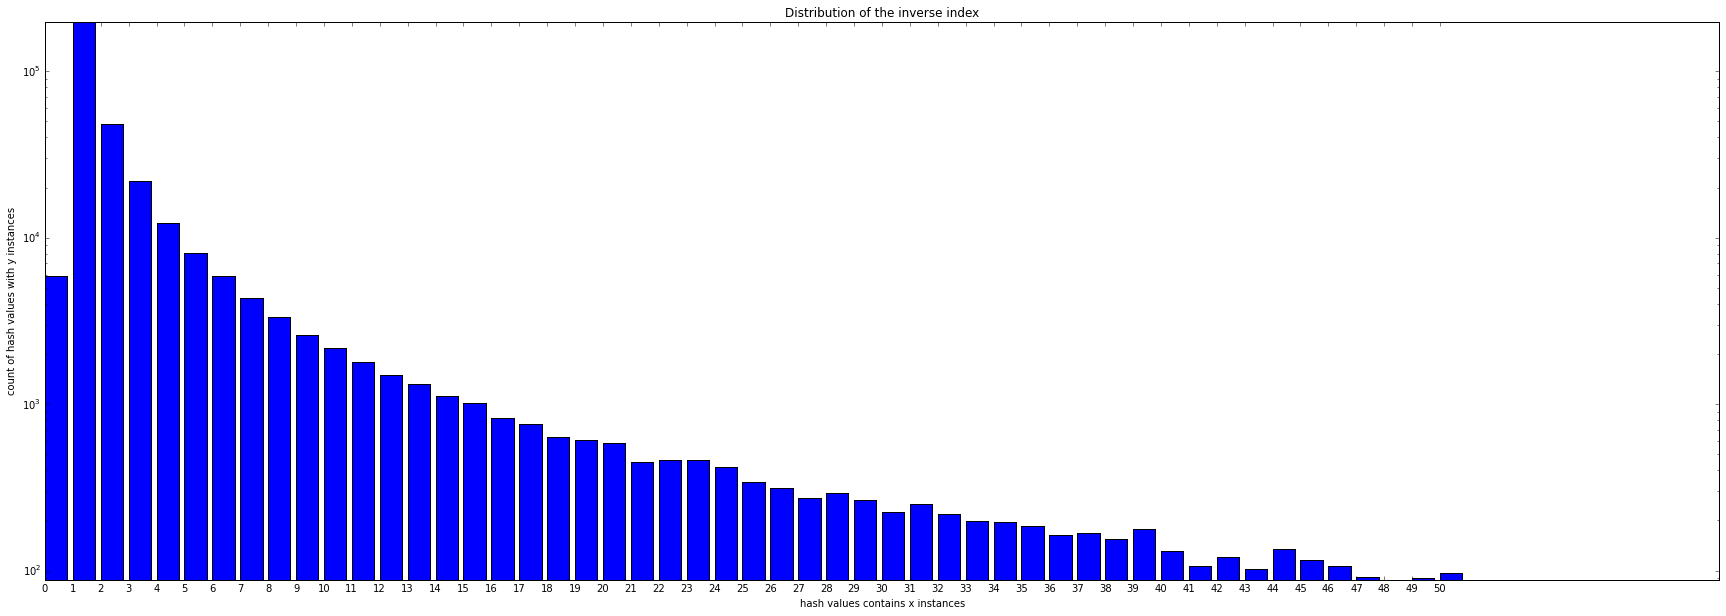

In [7]:
X = np.arange(len(distribution[0]))
plt.figure(figsize=(30, 10))
plt.yscale('log')
plt.bar(X, distribution[0].values())
plt.xticks(X, distribution[0].keys())
ymax = max(distribution[0].values())
plt.ylim(0, ymax)
plt.ylabel("count of hash values with y instances")
plt.xlabel("hash values contains x instances")
plt.title("Distribution of the inverse index")
plt.show()

### Compute the maximum values for time, memory usage and the error value

In [8]:
n_neighbors_sklearn = NearestNeighbors()
n_neighbors_sklearn.fit(datasetBursi)
neighbors_sklearn = n_neighbors_sklearn.kneighbors(return_distance=False)
accuracy_max = []
time_fit_max = []
time_kneighbors_max = []
distribution_inverse_index_max = []

for i in xrange(10):
    n_neighbors_minHash = MinHash(number_of_hash_functions=400, block_size=1)
    time_start = time.time()
    n_neighbors_minHash.fit(datasetBursi)
    distribution_inverse_index_max.append(n_neighbors_minHash.get_distribution_of_inverse_index())
    time_end = time.time() - time_start
    time_fit_max.append(time_end)
    time_start = time.time()
    neighbors = n_neighbors_minHash.kneighbors(return_distance=False, fast=False)
    time_end = time.time() - time_start
    time_kneighbors_max.append(time_end)
    accuracy_value = 0
    for x, y in zip(neighbors, neighbors_sklearn):
        accuracy_value += accuracy_score(x, y)
    accuracy_max.append(1 - (accuracy_value / len(neighbors)))

In [9]:
max_error = np.average(accuracy_max)
max_time = np.average(time_kneighbors_max)
memory_list = []
for dist in distribution_inverse_index_max:
    value = 0
    for mem in dist[0]:
        value += dist[0][mem]
    memory_list.append(value)
        
max_memory = np.average(memory_list)


In [10]:
print max(distribution_inverse_index_max[0][0].iterkeys())

50


### Best pruning value for the frequency of occurences of hash values

In [11]:
n_neighbors_sklearn = NearestNeighbors()
n_neighbors_sklearn.fit(datasetBursi)
neighbors_sklearn = n_neighbors_sklearn.kneighbors(return_distance=False)
error_list = []
time_fit_list = []
time_kneighbors_list = []
iterations = 3
distribution_inverse_index = []
for value in xrange(max(distribution_inverse_index_max[0][0].iterkeys())+1):
    time_fit_ = 0
    error_ = 0
    time_kneighbors_ = 0
    distribution_inverse_index_ = []
    for i in xrange(iterations):
        n_neighbors_minHash_prune = MinHash(number_of_hash_functions=400, prune_inverse_index=value)
        time_start = time.time()
        n_neighbors_minHash_prune.fit(datasetBursi)
        distribution_inverse_index_.append(n_neighbors_minHash_prune.get_distribution_of_inverse_index())
        time_end = time.time() - time_start
        time_fit_ += time_end
        time_start = time.time()
        neighbors = n_neighbors_minHash_prune.kneighbors(return_distance=False, fast=False)
        time_end = time.time() - time_start
        time_kneighbors_ += time_end
        accuracy_value = 0
        for x, y in zip(neighbors, neighbors_sklearn):
            accuracy_value += accuracy_score(x, y)
        error_ += 1 - (accuracy_value / len(neighbors))
        %xdel neighbors
        %xdel n_neighbors_minHash_prune
    time_fit_list.append(time_fit_ / iterations)
    time_kneighbors_list.append(time_kneighbors_ / iterations)
    error_list.append(error_ / iterations)
    dict_for_memory = {}
    for i in xrange(iterations):
        dict_for_memory = dict(Counter(dict_for_memory)+Counter(distribution_inverse_index_[i][0]))
    dict_for_memory.update((x, y / iterations) for x, y in dict_for_memory.items())
    distribution_inverse_index.append([dict_for_memory])


In [12]:
memory_list = []
for dist in distribution_inverse_index:
    value = 0
    for mem in dist[0]:
        value += dist[0][mem]
    memory_list.append(value)

#### Stored elements in the inverse index after pruning hash values with an occurence less than n

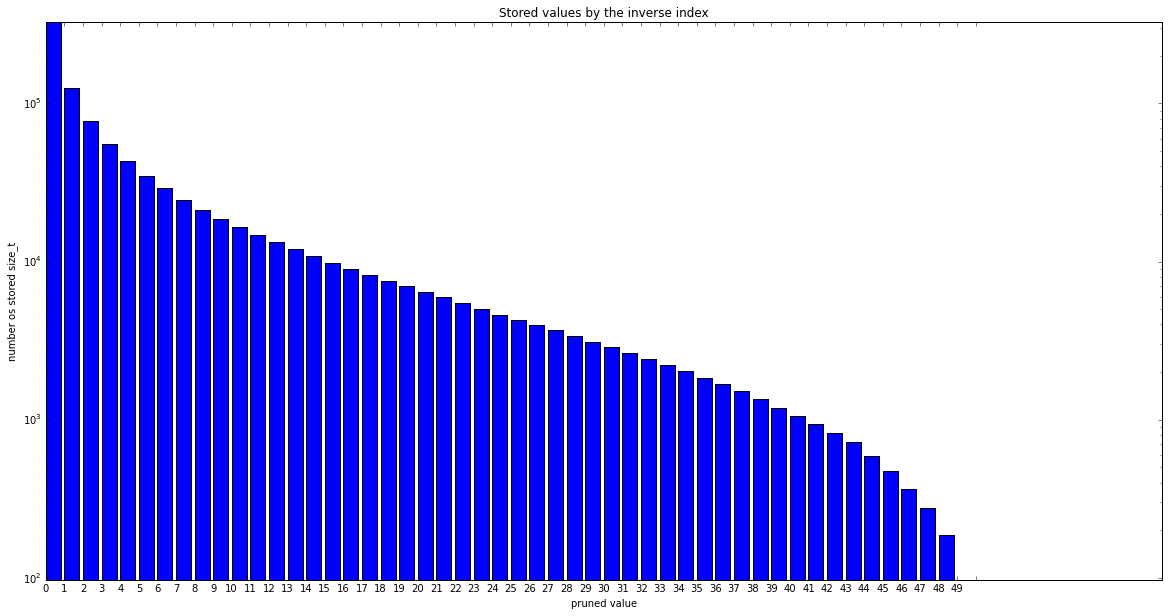

In [13]:
data = np.arange(len(memory_list))
plt.figure(figsize=(20, 10))
plt.yscale('log')
plt.bar(data, memory_list)
plt.xticks(data, range(max(distribution_inverse_index_max[0][0].iterkeys())))
ymax = max(memory_list)
plt.ylim(0, ymax)
plt.ylabel("number os stored size_t")
plt.xlabel("pruned value")
plt.title("Stored values by the inverse index")
plt.show()

#### Error value, fitting time and query time under the aspect of pruning of the inverse index

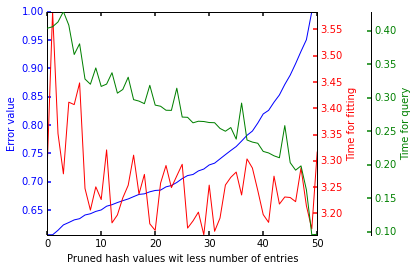

In [14]:
createPlot(range(max(distribution_inverse_index_max[0][0].iterkeys())+1), error_list, time_fit_list, time_kneighbors_list,
           "Pruned hash values wit less number of entries", "Error value",
           "Time for fitting", "Time for query")

#### Optimization for alpha and beta with respect to a minimal error value

In [15]:
min_error_value = 1
best_alpha = 0
best_beta = 0
best_score = 0
best_pruning_value = 0
epsilon = 0.05 # allow a variance of factor epsilon for the error value
for alpha_ in np.arange(0.01, 2 ,0.01):
    for beta_ in np.arange(0.01, 2, 0.01):
        result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, alpha=alpha_, beta=beta_)
#         print error_list[result[1][0][0]]
        if max_error + epsilon > error_list[result[1][0][0]]:
            if (min_error_value + epsilon) > error_list[result[1][0][0]]:
                best_score = result[0]
                best_alpha = alpha_
                best_beta = beta_
                min_error_value = error_list[result[1][0][0]]
                best_pruning_value = result[1][0][0]
            
print "alpha: ", best_alpha
print "beta: ", best_beta
print "Error value: ", min_error_value
print "Best pruning value: ", best_pruning_value
print "Score: ", best_score

alpha:  0.13
beta:  0.36
Error value:  0.650219045423
Best pruning value:  10
Score:  1.25490023055


#### Optimization for memory usage

Best value for pruning:  10  with value:  1.25490023055


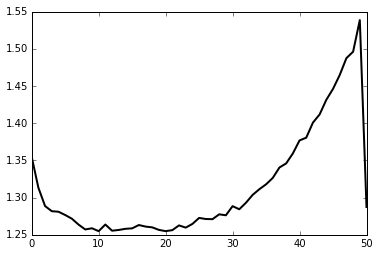

In [17]:
result = compute_score(error_list, memory_list, time_fit_list, max_memory, max_time, alpha=0.13, beta=0.36)
# print result
plt.plot(range(max(distribution_inverse_index_max[0][0].iterkeys())+1), result[2], 'k-', lw=2)
print "Best value for pruning: ", result[1][0][0], " with value: ", result[0]

### Influence to the accuracy if instances with a count of n are removed

In [15]:
n_neighbors_sklearn = NearestNeighbors()
n_neighbors_sklearn.fit(datasetBursi)
neighbors_sklearn = n_neighbors_sklearn.kneighbors(return_distance=False)
error_list = []
time_fit_list = []
time_kneighbors_list = []
iterations = 3
distribution_inverse_index = []
for value in sorted(distribution[1][0::10]):
    time_fit_ = 0
    error_ = 0
    time_kneighbors_ = 0
    distribution_inverse_index_ = []
    for i in xrange(iterations):
        n_neighbors_minHash_prune = MinHash(number_of_hash_functions=400,
                                        removeHashFunctionWithLessEntriesAs=value)
        time_start = time.time()
        n_neighbors_minHash_prune.fit(datasetBursi)
        distribution_inverse_index_.append(n_neighbors_minHash_prune.get_distribution_of_inverse_index())
        time_end = time.time() - time_start
        time_fit_ += time_end
        time_start = time.time()
        neighbors = n_neighbors_minHash_prune.kneighbors(return_distance=False, fast=False)
        time_end = time.time() - time_start
        time_kneighbors_ += time_end
        accuracy_value = 0
        for x, y in zip(neighbors, neighbors_sklearn):
            accuracy_value += accuracy_score(x, y)
        error_ += 1 - (accuracy_value / len(neighbors))
        %xdel -n neighbors
        %xdel -n n_neighbors_minHash_prune
#         del n_neighbors_minHash_prune
    time_fit_list.append(time_fit_ / iterations)
    time_kneighbors_list.append(time_kneighbors_ / iterations)
    error_list.append(error_ / iterations)
    dict_for_memory = {}
    for i in xrange(iterations):
        dict_for_memory = dict(Counter(dict_for_memory)+Counter(distribution_inverse_index_[i][0]))
    dict_for_memory.update((x, y / iterations) for x, y in dict_for_memory.items())
    distribution_inverse_index.append([dict_for_memory])
    
    gc.collect()

KeyboardInterrupt: 

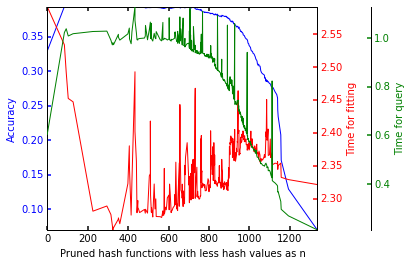

In [9]:
createPlot(sorted(distribution[1]), accuracy, time_fit, time_kneighbors, "Pruned hash functions with less hash values as n",
           "Accuracy", "Time for fitting", "Time for query")

[58413, 322491, 318728, 314205, 309148, 303699, 298408, 291596, 285124, 278449, 272950, 266593, 257952, 249805, 242974, 235307, 226689, 218702, 211421, 204042, 194076, 185628, 177038, 168310, 160336, 151390, 141460, 132311, 123085, 113775, 104329, 94785, 85136, 75364, 66443, 55367, 45068, 34563, 23801, 12778, 1335]
Mean:  808


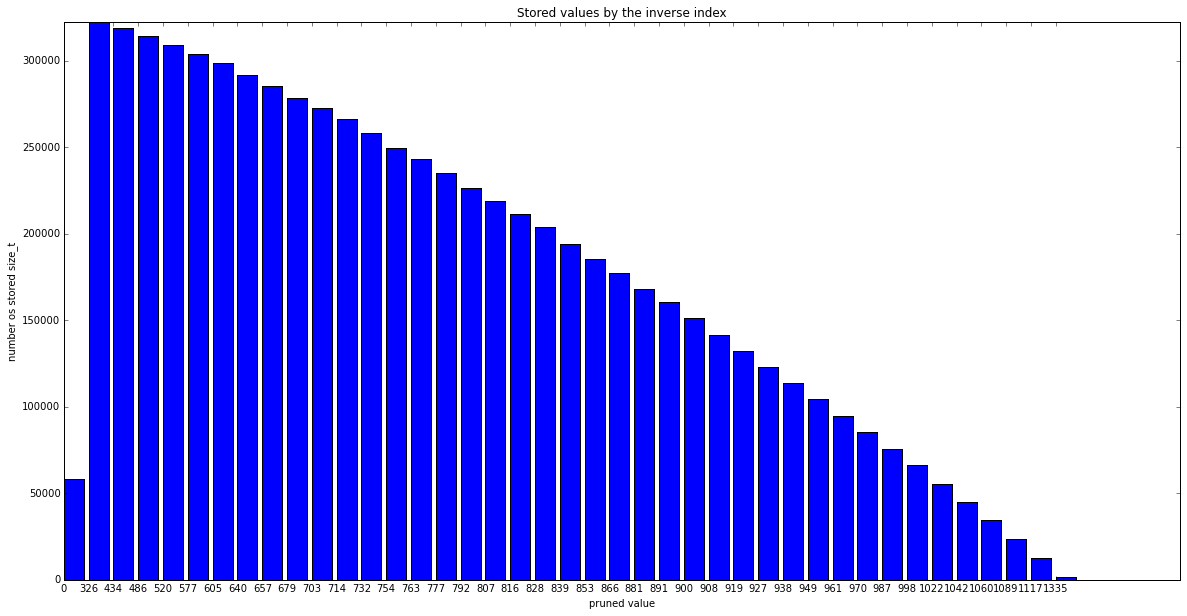

In [36]:
elements_in_index = []
for instance in distribution_inverse_index[0::10]:
    value = 0
    for data in instance[0]:
        value += instance[0][data]
    elements_in_index.append(value)
print elements_in_index

mean = 0
for i in sorted(distribution[1]):
    mean += i
print "Mean: ", mean / len(distribution[1])
data = np.arange(len(elements_in_index))
plt.figure(figsize=(20, 10))
plt.bar(data, elements_in_index)
plt.xticks(data, sorted(distribution[1])[0::10])
ymax = max(elements_in_index)
plt.ylim(0, ymax)
plt.ylabel("number os stored size_t")
plt.xlabel("pruned value")
plt.title("Stored values by the inverse index")
plt.show()

In [ ]:
print "std: ", distribution[5]